### 1. You are tasked with identifying high-value customer segments for Yamaha motorcycle marketing.
##### Use features: monthly_income, purchase_intent_score, and visit_frequency to create 3 customer segments.
##### Then:
##### a. Plot the clusters using a scatterplot (e.g., Income vs Intent Score, colored by cluster)
##### b. Provide business names for each cluster (e.g., "Young Urban Explorers", "Budget Commuters")

In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap

In [3]:
geo_data = pd.read_csv("yamaha_customer_data_with_geo.csv")

In [4]:
features = geo_data[['monthly_income', 'purchase_intent_score', 'visit_frequency']]

In [5]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [6]:
kmeans = KMeans(n_clusters=3, random_state=42)
geo_data['cluster'] = kmeans.fit_predict(scaled_features)

d:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


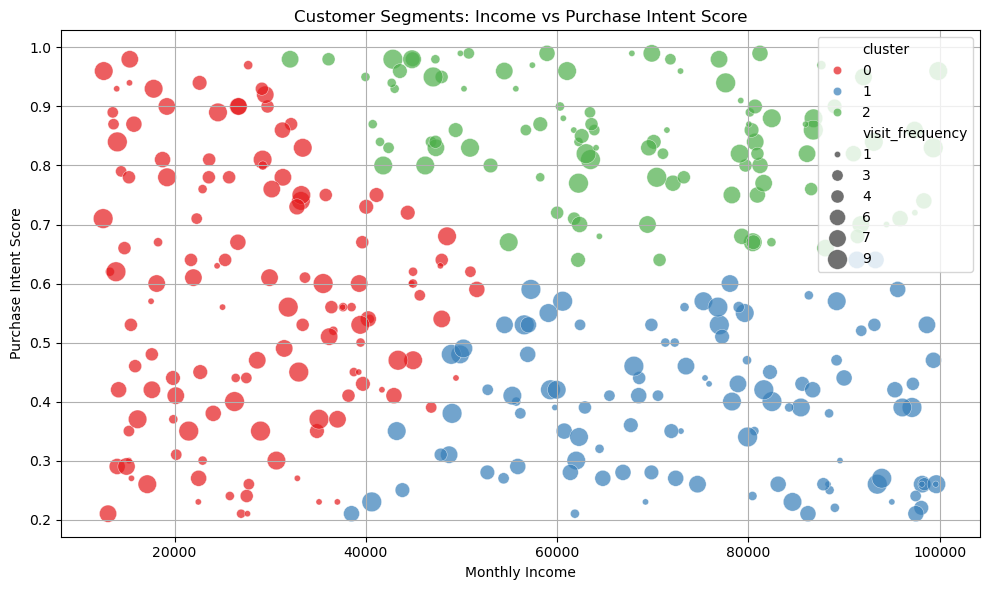

In [7]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=geo_data['monthly_income'],
    y=geo_data['purchase_intent_score'],
    hue=geo_data['cluster'],
    size=geo_data['visit_frequency'],
    sizes=(20, 200),
    alpha=0.7,
    palette='Set1'
)

plt.title("Customer Segments: Income vs Purchase Intent Score")
plt.xlabel("Monthly Income")
plt.ylabel("Purchase Intent Score")
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
def name_cluster(row):
    if row['cluster'] == 0:
        return "Budget Commuters"
    elif row['cluster'] == 1:
        return "Young Urban Explorers"
    else:
        return "Premium Seekers"


In [9]:
geo_data['segment_name'] = geo_data.apply(name_cluster, axis=1)

In [10]:
segment_summary = geo_data.groupby("segment_name").agg(
    average_income=('monthly_income', 'mean'),
    average_visits=('visit_frequency', 'mean'),
    average_intent_score=('purchase_intent_score', 'mean')
).reset_index()

In [11]:
segment_counts = geo_data['segment_name'].value_counts().reset_index()
segment_counts.columns = ['segment_name', 'customer_count']

In [12]:
combined_summary = pd.merge(segment_counts, segment_summary, on='segment_name')


print(combined_summary)

            segment_name  customer_count  average_income  average_visits  \
0       Budget Commuters             133    28634.195489        4.759398   
1  Young Urban Explorers             111    74532.855856        5.360360   
2        Premium Seekers             106    67836.433962        4.849057   

   average_intent_score  
0              0.579098  
1              0.392703  
2              0.845849  


### 2. Use the latitude and longitude columns to:
##### a. Plot customer density using a scatter plot or heatmap. (Hint - you can use matplotlib/folium/plotly (python) or ggplot2/leaflet/ggplotly (R-programming) )

In [13]:
center = [geo_data["latitude"].mean(), geo_data["longitude"].mean()]

In [14]:
m = folium.Map(location=center, zoom_start=7, tiles="CartoDB positron")

In [15]:
heat_data = geo_data[["latitude", "longitude"]].values.tolist()
HeatMap(heat_data, radius=10, blur=15).add_to(m)

In [16]:
m.save("customer_density_heatmap.html")
print("Heat-map saved → customer_density_heatmap.html")

Heat-map saved → customer_density_heatmap.html


In [17]:
import webbrowser
webbrowser.open("customer_density_heatmap.html")

True

##### b. Highlight which upazilas appear most attractive for targeting sports bikes or premium campaigns

In [36]:
sports_only = geo_data[geo_data["product_type"] == "Sports"]

In [37]:
grouped = sports_only.groupby("upazila").agg(
    latitude=('latitude', 'mean'),
    longitude=('longitude', 'mean'),
    customer_count=('customer_id', 'count'),
    average_income=('monthly_income', 'mean'),
    average_intent=('purchase_intent_score', 'mean')
).reset_index()

In [38]:
grouped["norm_income"] = grouped["average_income"] / grouped["average_income"].max()
grouped["norm_customers"] = grouped["customer_count"] / grouped["customer_count"].max()
grouped["norm_intent"] = grouped["average_intent"]  # already 0–1

In [39]:
grouped["heat_score"] = (
    grouped["norm_income"] +
    grouped["norm_customers"] +
    grouped["norm_intent"]
) / 3

In [40]:
m = folium.Map(
    location=[sports_only["latitude"].mean(), sports_only["longitude"].mean()],
    zoom_start=7
)

In [41]:
heat_data_equal = [
    [row["latitude"], row["longitude"], row["heat_score"]]
    for _, row in grouped.iterrows()
]

In [42]:
HeatMap(heat_data_equal, radius=15, max_zoom=13).add_to(m)

In [43]:
top_upazilas = grouped.sort_values(by="heat_score", ascending=False).head(5)
print("\n🔥 Top 5 Most Attractive Upazilas (Equal Importance):")
print(top_upazilas[["upazila", "customer_count", "average_income", "average_intent", "heat_score"]])



🔥 Top 5 Most Attractive Upazilas (Equal Importance):
       upazila  customer_count  average_income  average_intent  heat_score
1   Banaripara              14    53115.928571        0.549286    0.797470
11     Trishal               9    62548.888889        0.645556    0.760423
7     Phultala               8    61225.750000        0.722500    0.755260
5   Muradnagar              10    62999.000000        0.524000    0.746095
8       Rupsha               8    59258.250000        0.670000    0.727350


In [44]:
for _, row in top_upazilas.iterrows():
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=10,
        color="red",
        fill=True,
        fill_color="red",
        fill_opacity=0.8,
        popup=folium.Popup(row["upazila"], parse_html=True)
    ).add_to(m)

In [45]:
m.save("upazila_weighted_heatmap.html")
print("✅ Heatmap saved as upazila_weighted_heatmap.html")

✅ Heatmap saved as upazila_weighted_heatmap.html


In [46]:
import webbrowser
webbrowser.open("upazila_weighted_heatmap.html")

True

### Q6. High-Potential Upazilas [SQL or Python]
#### Find the top 3 upazilas where:
- a. Average monthly income > 50,000
- b. Average intent score > 0.6
- c. AND product interest is in Sports or Scooter
#### Provide:
- d. Upazila name, customer count, average income, and product type(s)

In [47]:
mask_products = geo_data["product_type"].isin(["Sports", "Scooter"])
df_focus = geo_data[mask_products]

In [48]:
agg = (
    df_focus.groupby("upazila")
    .agg(
        customer_count   = ("customer_id", "count"),
        average_income   = ("monthly_income", "mean"),
        average_intent   = ("purchase_intent_score", "mean"),
        product_types    = ("product_type", lambda x: ", ".join(sorted(x.unique())))
    )
    .reset_index()
)


In [49]:
high_potential = agg[
    (agg["average_income"]  > 50000) &
    (agg["average_intent"]  > 0.6)
].sort_values(by="average_intent", ascending=False)


In [50]:
top_3 = high_potential.head(3)

print("\n🎯 Top 3 High-Potential Upazilas (Sports Only | income > 50k | intent > 0.6):")
print(top_3.to_string(index=False))


🎯 Top 3 High-Potential Upazilas (Sports Only | income > 50k | intent > 0.6):
 upazila  customer_count  average_income  average_intent   product_types
  Rupsha              14    57144.857143        0.678571 Scooter, Sports
Godagari              18    65565.000000        0.668333 Scooter, Sports
 Trishal              13    55315.615385        0.655385 Scooter, Sports
